In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

from lung_map_utils import utils
from lung_map_utils_extra import utils_extra

%matplotlib inline

In [4]:
fig_size = (6, 6)

img_file = "data/55.png"
img = cv2.imread(img_file)
img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
img_rgb = cv2.cvtColor(img_hsv, cv2.COLOR_HSV2RGB)
img_s = img_hsv[:, :, 1]

img_shape = (img.shape[0], img.shape[1])

cross_strel = cv2.getStructuringElement(cv2.MORPH_CROSS, (3, 3))

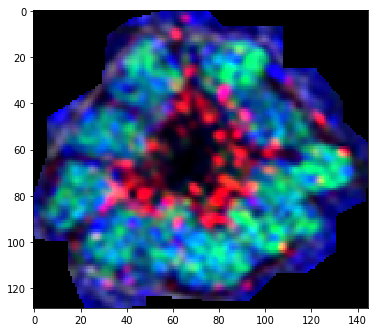

In [5]:
fig = plt.figure(figsize=fig_size)
plt.imshow(img_rgb)

### First, try the obvious and simplest options using various thresholding

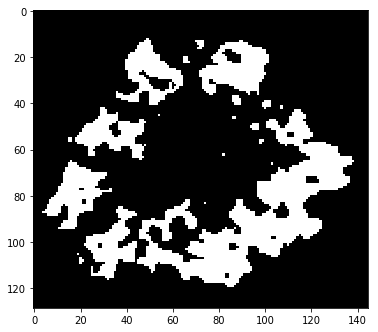

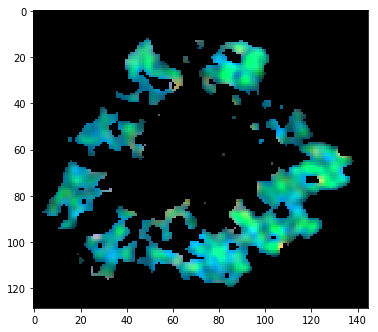

In [27]:
green_color_mask = utils.create_mask(
    img_hsv,
    [
        'green', 'cyan', 'white_blue', 'yellow'
    ]
)

fig = plt.figure(figsize=fig_size)
plt.imshow(green_color_mask, cmap='gray')

green_color_mask_img = cv2.bitwise_and(img_rgb, img_rgb, mask=green_color_mask)

fig = plt.figure(figsize=fig_size)
plt.imshow(green_color_mask_img)

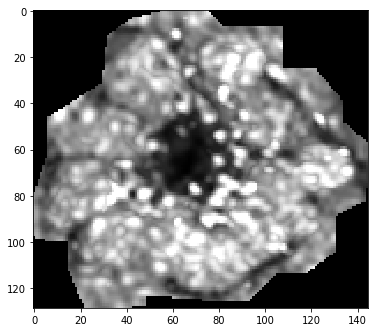

In [7]:
fig = plt.figure(figsize=fig_size)
plt.imshow(img_hsv[:, :, 2], cmap='gray')

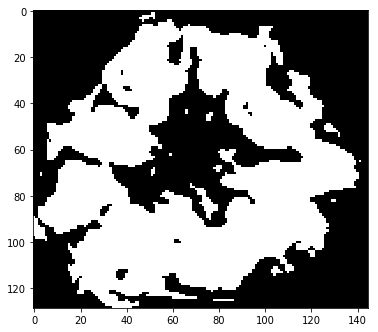

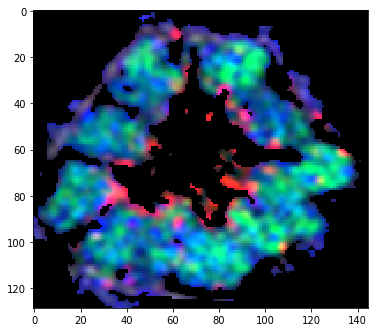

In [30]:
# and just the thresholded green channel from RGB
g_img = img_rgb[:, :, 1]
g_mask = g_img > 31
g_mask = g_mask.astype(np.uint8)

fig = plt.figure(figsize=fig_size)
plt.imshow(g_mask, cmap='gray')

g_mask_img = cv2.bitwise_and(img_rgb, img_rgb, mask=g_mask)

fig = plt.figure(figsize=fig_size)
plt.imshow(g_mask_img)

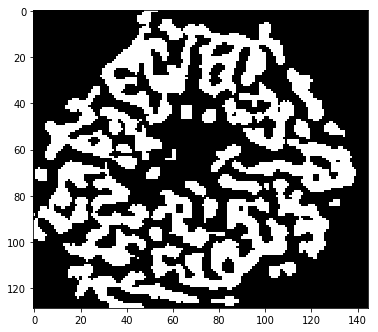

In [52]:
# see if we can find some edges from the original value channel
v_img = cv2.cvtColor(g_mask_img, cv2.COLOR_RGB2HSV)[:, :, 2]

# diff of gaussians
img_blur_1 = cv2.blur(v_img, (5, 5))
img_blur_2 = cv2.blur(v_img, (9, 9))

tmp_img_1 = img_blur_1.astype(np.int16)
tmp_img_2 = img_blur_2.astype(np.int16)

edge_mask = tmp_img_2 - tmp_img_1
edge_mask[edge_mask > 0] = 0
edge_mask[edge_mask < 0] = 255

edge_mask = edge_mask.astype(np.uint8)

fig = plt.figure(figsize=fig_size)
plt.imshow(cv2.cvtColor(edge_mask, cv2.COLOR_GRAY2RGB))

### Now, what about pre-processing with a little blurring

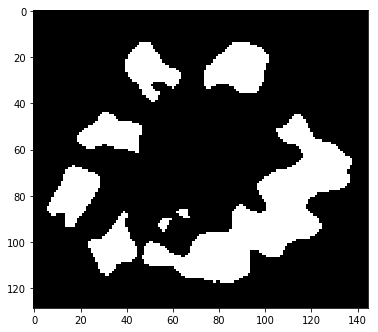

In [59]:
blur_img_rgb = cv2.GaussianBlur(img_rgb, (15, 15), 0, 0)

green_color_mask = utils.create_mask(
    cv2.cvtColor(blur_img_rgb, cv2.COLOR_RGB2HSV),
    [
        'green', 'cyan'
    ]
)

fig = plt.figure(figsize=fig_size)
plt.imshow(green_color_mask, cmap='gray')

In [9]:
blur3_img_rgb = cv2.blur(img_rgb, (3, 3))
blur5_img_rgb = cv2.blur(img_rgb, (5, 5))
blur7_img_rgb = cv2.blur(img_rgb, (7, 7))

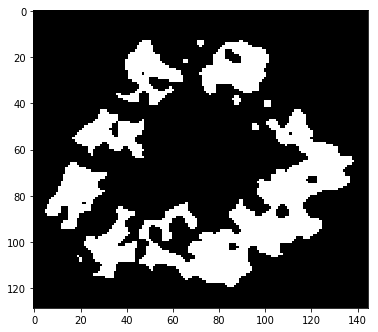

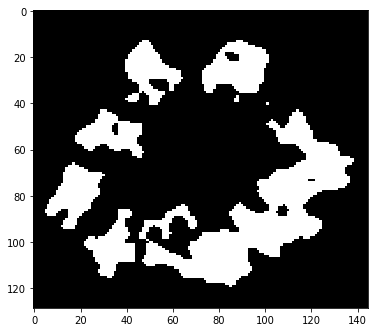

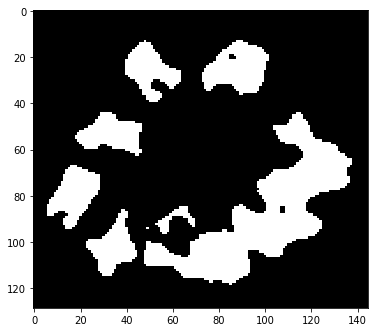

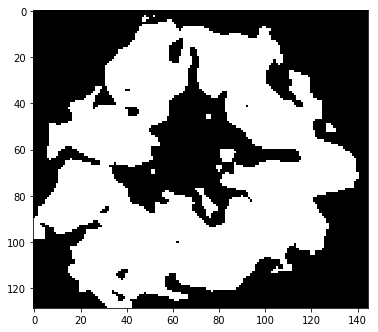

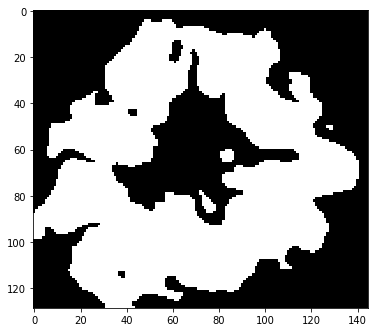

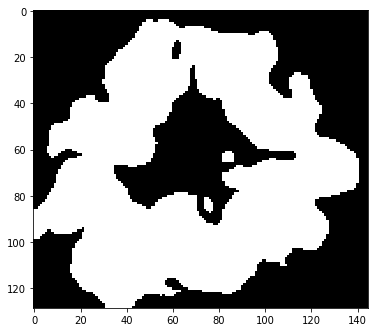

In [10]:
green_color_mask = utils.create_mask(
    cv2.cvtColor(blur3_img_rgb, cv2.COLOR_RGB2HSV),
    [
        'green', 'cyan'
    ]
)

fig = plt.figure(figsize=fig_size)
plt.imshow(green_color_mask, cmap='gray')

green_color_mask = utils.create_mask(
    cv2.cvtColor(blur5_img_rgb, cv2.COLOR_RGB2HSV),
    [
        'green', 'cyan'
    ]
)

fig = plt.figure(figsize=fig_size)
plt.imshow(green_color_mask, cmap='gray')

green_color_mask = utils.create_mask(
    cv2.cvtColor(blur7_img_rgb, cv2.COLOR_RGB2HSV),
    [
        'green', 'cyan'
    ]
)

fig = plt.figure(figsize=fig_size)
plt.imshow(green_color_mask, cmap='gray')

g_img = blur3_img_rgb[:, :, 1]
g_mask = g_img > 31

fig = plt.figure(figsize=fig_size)
plt.imshow(g_mask, cmap='gray')

g_img = blur5_img_rgb[:, :, 1]
g_mask = g_img > 31

fig = plt.figure(figsize=fig_size)
plt.imshow(g_mask, cmap='gray')

g_img = blur7_img_rgb[:, :, 1]
g_mask = g_img > 31

fig = plt.figure(figsize=fig_size)
plt.imshow(g_mask, cmap='gray')

### Difference of Blurs

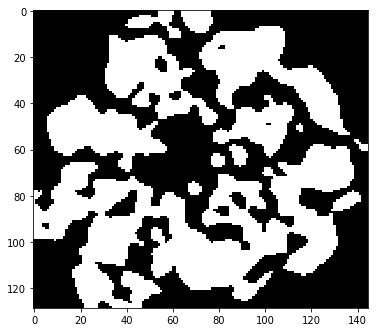

In [11]:
# see if we can find some edges from the original value channel
v_img = img_hsv[:, :, 2]

# diff of gaussians
img_blur_1 = cv2.blur(v_img, (5, 5))
img_blur_2 = cv2.blur(v_img, (31, 31))

tmp_img_1 = img_blur_1.astype(np.int16)
tmp_img_2 = img_blur_2.astype(np.int16)

edge_mask = tmp_img_2 - tmp_img_1
edge_mask[edge_mask > 0] = 0
edge_mask[edge_mask < 0] = 255

edge_mask = edge_mask.astype(np.uint8)

fig = plt.figure(figsize=fig_size)
plt.imshow(cv2.cvtColor(edge_mask, cv2.COLOR_GRAY2RGB))

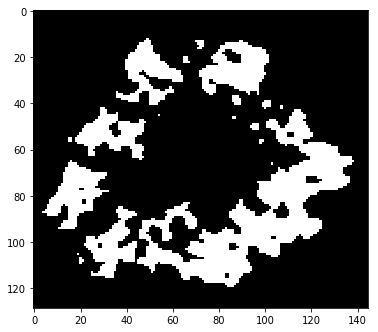

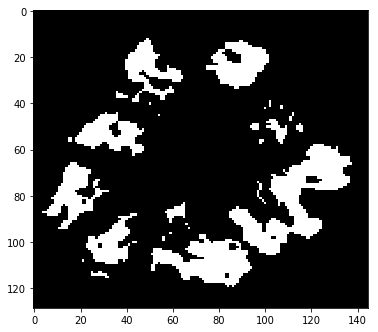

In [12]:
# what if we mask our green candidates with the edges
green_color_mask = utils.create_mask(
    img_hsv,
    [
        'green', 'cyan'
    ]
)

fig = plt.figure(figsize=fig_size)
plt.imshow(green_color_mask, cmap='gray')

tmp_mask = np.bitwise_and(green_color_mask, edge_mask)

fig = plt.figure(figsize=fig_size)
plt.imshow(tmp_mask, cmap='gray')

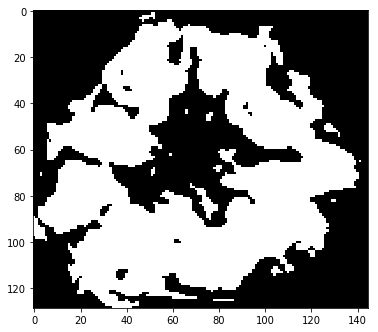

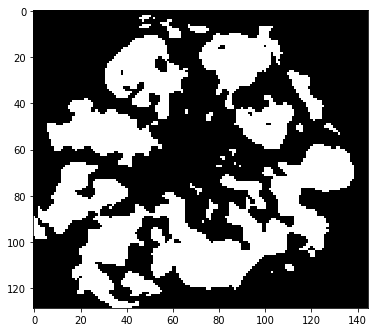

In [13]:
# and the green threshold masked with the edges
g_img = img_rgb[:, :, 1]
g_mask = g_img > 31
g_mask = g_mask.astype(np.uint8)
g_mask[g_mask > 0] = 255

fig = plt.figure(figsize=fig_size)
plt.imshow(g_mask, cmap='gray')

tmp_mask = np.bitwise_and(g_mask, edge_mask)

fig = plt.figure(figsize=fig_size)
plt.imshow(tmp_mask, cmap='gray')

### The best so far, erode and clean up the small pieces, then dilate back

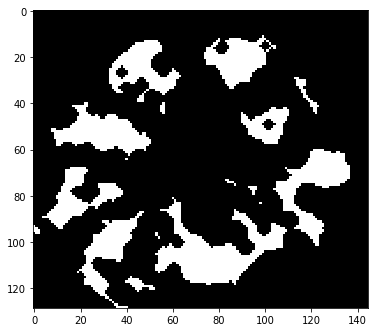

In [14]:
tmp_mask2 = cv2.erode(tmp_mask, cross_strel, iterations=2)

fig = plt.figure(figsize=fig_size)
plt.imshow(tmp_mask2, cmap='gray')

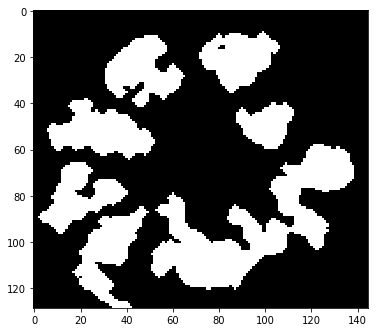

In [15]:
# Next, clean up any sub-cellular regions, say, ~ 15 x 15
contours = utils_extra.filter_contours_by_size(tmp_mask2, min_size=15*15, max_size=140*140)

tmp_mask3 = np.zeros(img_shape, dtype=np.uint8)
tmp_mask3 = cv2.drawContours(tmp_mask3, contours, -1, 255, -1)

tmp_mask3 = cv2.dilate(tmp_mask3, cross_strel, iterations=2)

fig = plt.figure(figsize=fig_size)
plt.imshow(tmp_mask3, cmap='gray')

### Still not good enough to reliably find cells

What about excluding the colors of non-interest

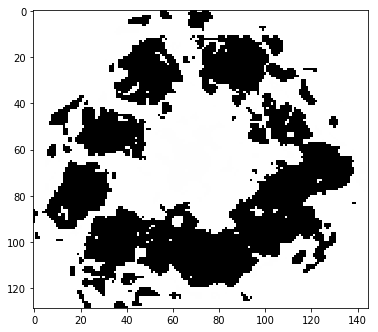

In [16]:
# remove any other color markers
other_color_mask = utils.create_mask(
    img_hsv,
    [
        'red', 'violet', 'black', 'gray', 'dark_blue', 'yellow'
    ]
)

fig = plt.figure(figsize=fig_size)
plt.imshow(other_color_mask, cmap='gray')

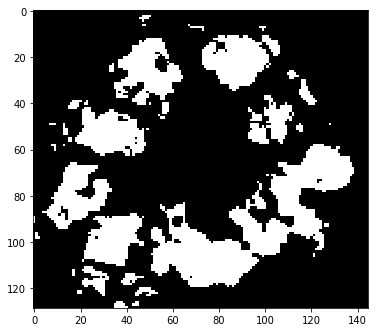

In [17]:
tmp_mask2 = np.bitwise_and(tmp_mask, ~other_color_mask)

fig = plt.figure(figsize=fig_size)
plt.imshow(tmp_mask2, cmap='gray')

### What if we blur a bit first

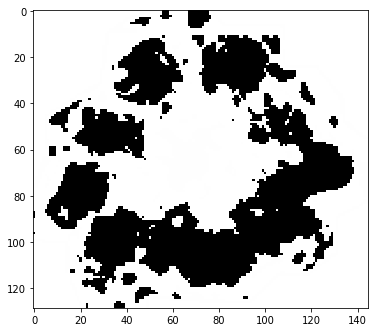

In [18]:
# and the green threshold masked with the edges
# remove any other color markers
other_color_mask = utils.create_mask(
    cv2.cvtColor(blur3_img_rgb, cv2.COLOR_RGB2HSV),
    [
        'red', 'violet', 'black', 'gray', 'dark_blue', 'yellow'
    ]
)

fig = plt.figure(figsize=fig_size)
plt.imshow(other_color_mask, cmap='gray')

### It's worse, what about median blur?

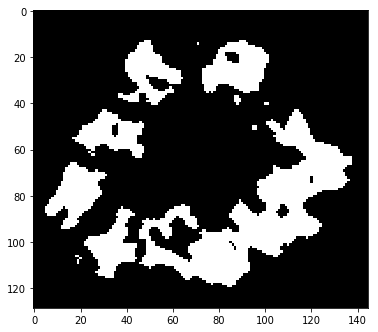

In [23]:
blur_med_img_rgb = cv2.medianBlur(img_rgb, 5)
#blur_med_img_rgb = cv2.blur(blur_med_img_rgb, (3, 3)) 

# and the green threshold masked with the edges
# remove any other color markers
other_color_mask = utils.create_mask(
    cv2.cvtColor(blur_med_img_rgb, cv2.COLOR_RGB2HSV),
    [
        #'red', 'violet', 'black', 'gray', 'dark_blue', 'yellow', 'white_blue', 'white', 'blue'
        'cyan', 'green'
    ]
)

fig = plt.figure(figsize=fig_size)
plt.imshow(other_color_mask, cmap='gray')

### Just for fun, what does the contour look like in our color categories

In [66]:
rgb_color_lut = {
    'white': (255, 255, 255),
    'red': (223, 7, 7),
    'gray': (63, 63, 63),
    'blue': (7, 7, 255),
    'yellow': (255, 255, 0),
    'green': (0, 223, 0),
    'cyan': (0, 255, 255),
    'violet': (255, 0, 255),
    'black': (0, 0, 0)
}

rgb2_color_lut = {
    'dark_blue': (0, 0, 160),
    'white_blue': (160, 160, 255)
}

In [67]:
pseudo_color_img = np.zeros(img_rgb.shape, dtype=np.uint8)

In [68]:
for color, value in rgb_color_lut.items():
    color_mask = utils.create_mask(cv2.cvtColor(img_rgb, cv2.COLOR_RGB2HSV), [color])
    
    pseudo_color_img[color_mask>0] = value

# for color, value in rgb2_color_lut.items():
#     color_mask = utils.create_mask(cv2.cvtColor(img_rgb, cv2.COLOR_RGB2HSV), [color])
    
#     pseudo_color_img[color_mask>0] = value

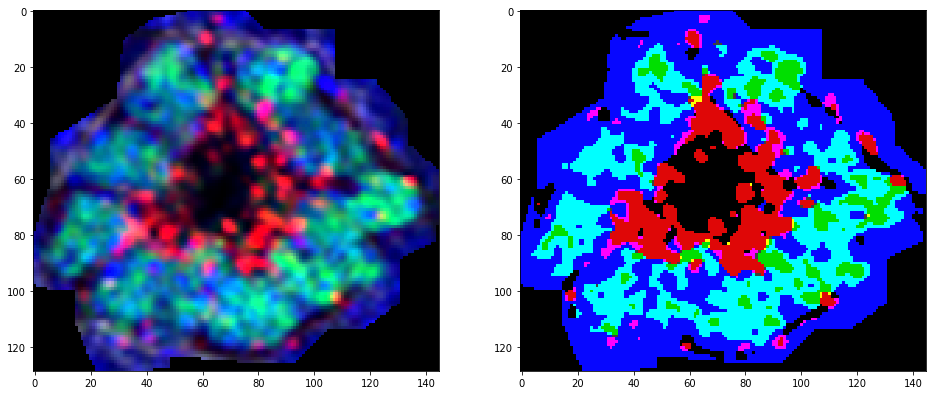

In [69]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
ax1.imshow(img_rgb)
ax2.imshow(pseudo_color_img)

### Suppress the "blue" pixels

In [ ]:
b_over_r = img_rgb[:, :, 0] < img_rgb[:, :, 2]
b_over_g = img_rgb[:, :, 1] < img_rgb[:, :, 2]

b_over_rg = np.bitwise_and(b_over_r, b_over_g)

b_replace = np.max([img_rgb[:, :, 0], img_rgb[:, :, 1]], axis=0)

b_suppress_img = img_rgb.copy()
b_suppress_img[b_over_rg, 2] = b_replace[b_over_rg]
b_suppress_img_hsv = cv2.cvtColor(b_suppress_img, cv2.COLOR_RGB2HSV)

In [ ]:
fig = plt.figure(figsize=fig_size)
plt.imshow(b_suppress_img)

In [ ]:
enhanced_img_hsv = cv2.bitwise_and(b_suppress_img_hsv, b_suppress_img_hsv, mask=edge_mask)

fig = plt.figure(figsize=fig_size)
plt.imshow(cv2.cvtColor(enhanced_img_hsv, cv2.COLOR_HSV2RGB))

In [ ]:
enhanced_v_img = enhanced_img_hsv[:, :, 2]

# diff of gaussians
img_blur_1 = cv2.blur(enhanced_v_img, (5, 5))
img_blur_2 = cv2.blur(enhanced_v_img, (31, 31))

tmp_img_1 = img_blur_1.astype(np.int16)
tmp_img_2 = img_blur_2.astype(np.int16)

edge_mask = tmp_img_2 - tmp_img_1
edge_mask[edge_mask >= -5] = 0
edge_mask[edge_mask < -5] = 255

edge_mask = edge_mask.astype(np.uint8)

fig = plt.figure(figsize=fig_size)
plt.imshow(cv2.cvtColor(edge_mask, cv2.COLOR_GRAY2RGB))